In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

In [2]:
from utils import remove_items, split_data, group_color

In [3]:
def clean_df(x):
    """
    function to clean dataframe and keep selected columns

    input : x, columns to keep in dataframe
    output: styles, modified dataframe
    """

    styles = pd.read_csv("data/styles.csv", on_bad_lines='skip')

    # drop unnecessary columns which are not needed to make recommendation
    styles = styles.drop(["productDisplayName"], axis=1)
    styles = styles.drop(["year"], axis=1)
    styles = styles[(styles.masterCategory=='Apparel')| (styles.masterCategory=='Footwear')]
    styles = styles.drop(styles[styles["subCategory"]=="Innerwear"].index)
    styles = styles.dropna()

    styles = remove_items(styles,"subCategory", ["Apparel Set", "Dress", "Loungewear and Nightwear", "Saree", "Socks"])
    styles["subCategory"] = styles["subCategory"].transform(lambda x: "Footwear" if(x in ["Shoes", "Flip Flops", "Sandal"]) else x)
    styles = styles.drop(labels=[6695, 16194, 32309, 36381, 40000], axis=0) # drop incomplete rows
    styles = styles[styles.subCategory==x]

    # group colors to the color-wheel
    group_color(styles)
    styles.baseColour=styles.colorgroup
    
    return styles

In [4]:
topwear_df    = clean_df("Topwear")
bottomwear_df = clean_df("Bottomwear")
footwear_df   = clean_df("Footwear")

In [5]:
topwear_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,colorgroup
0,15970,Men,Apparel,Topwear,Shirts,9,Fall,Casual,9
4,53759,Men,Apparel,Topwear,Tshirts,14,Summer,Casual,14
5,1855,Men,Apparel,Topwear,Tshirts,14,Summer,Casual,14
6,30805,Men,Apparel,Topwear,Shirts,6,Summer,Ethnic,6
7,26960,Women,Apparel,Topwear,Shirts,10,Summer,Casual,10


In [6]:
bottomwear_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,colorgroup
1,39386,Men,Apparel,Bottomwear,Jeans,8,Summer,Casual,8
3,21379,Men,Apparel,Bottomwear,Track Pants,12,Fall,Casual,12
46,18005,Men,Apparel,Bottomwear,Shorts,12,Summer,Sports,12
68,54924,Men,Apparel,Bottomwear,Shorts,8,Summer,Casual,8
100,28456,Women,Apparel,Bottomwear,Skirts,8,Summer,Sports,8


In [7]:
footwear_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,usage,colorgroup
10,9204,Men,Footwear,Footwear,Casual Shoes,12,Summer,Casual,12
12,18653,Men,Footwear,Footwear,Flip Flops,12,Fall,Casual,12
14,46885,Boys,Footwear,Footwear,Flip Flops,9,Fall,Casual,9
21,12967,Men,Footwear,Footwear,Sandals,12,Fall,Casual,12
25,9036,Men,Footwear,Footwear,Formal Shoes,12,Winter,Formal,12


In [8]:
def encode_labels(styles):
    """
    function to encode data 

    input : styles, dataframe to encode
    output: styles, (encoded) dataframe 
            articleTypeLB, genderLB, baseColourLB, seasonLB, usageLB: all labelEncoders
    """

    articleTypeLB = LabelEncoder()
    genderLB      = LabelEncoder()
    baseColourLB  = LabelEncoder()
    seasonLB      = LabelEncoder()
    usageLB       = LabelEncoder()

    styles['articleType'] = articleTypeLB.fit_transform(styles['articleType'])
    styles['gender']      = genderLB.fit_transform(styles['gender'])
    styles['baseColour']  = baseColourLB.fit_transform(styles['baseColour'])
    styles['season']      = seasonLB.fit_transform(styles['season'])
    styles['usage']       = usageLB.fit_transform(styles['usage'])

    return styles, articleTypeLB, genderLB, baseColourLB, seasonLB, usageLB

In [9]:
# convert text fields to one-hot encoded values
topwear_df, top_article, top_gender, top_color, top_season, top_usage = encode_labels(topwear_df)
bottomwear_df, bottom_article, bottom_gender, bottom_color, bottom_season, bottom_usage = encode_labels(bottomwear_df)
footwear_df, foot_article, foot_gender, foot_color, foot_season, foot_usage = encode_labels(footwear_df)

In [10]:
print(topwear_df['articleType'], top_article)

0        11
4        17
5        17
6        11
7        11
         ..
44414    17
44415    17
44417    17
44418    16
44421    17
Name: articleType, Length: 15383, dtype: int64 LabelEncoder()


In [11]:
def create_array(df):
      """
      function to fetch dataset; to give as input to model
      
      input : dataframe
      return: data
      """

      train_imgs = np.zeros((len(df.id), 80, 60, 3))

      for i in range(len(df.id)):
          
        ID = df.id.iloc[i]
        img_path = f"data/images/{ID}.jpg"   
        img = cv2.imread(img_path)
      
        if img.shape != (80, 60, 3):
            img = image.load_img(img_path, target_size=(80, 60, 3))
        
        train_imgs[i] = img
      
      data = tf.data.Dataset.from_tensor_slices(
        (
          {
            "images" : train_imgs
          },

          {
            'articleType': df[['articleType']],
            'gender'    : df[['gender']],
            'baseColour': df[['baseColour']],
            'season'    : df[['season']],
            'usage'     : df[['usage']]
          }
        )
      )

      return data

In [12]:
def add_layers(resnet_input, num_classes, activation, name):
        """
        function to build model branch

        input : resnet_input: keras.Input
                num_classes : number of output classes
                activation  : type of activation
                name        : output name
        return: final layer output
        """

        x = layers.Dense(512, activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.1))(resnet_input)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)
        x = layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.1))(x)
        x = layers.Dropout(0.25)(x)

        x = layers.Dense(num_classes)(x)
        x = layers.Activation(activation, name=name)(x)

        return x

In [13]:
def build_model(width, height, articleTypeLB, genderLB, baseColourLB, seasonLB, usageLB):
  """
  function to build model for categories

  input : width, image width 
          height, image height
  return: keras.Model
  """

  resnet50 = keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(80, 60, 3))
  resnet50.trainable=False

  inputs = keras.Input(shape=(width, height, 3), name="images")
  x = layers.RandomFlip("horizontal")(inputs)
  x = layers.RandomRotation(factor=0.2)(x)
  x = layers.RandomZoom(height_factor=0.1, width_factor=0.1)(x)
  x = layers.RandomContrast(factor=0.2)(x)

  x = resnet50(x, training=False)
  x = layers.Flatten()(x)
  x = layers.Dense(1024, activation='relu')(x)

  article_branch = add_layers(x, len(articleTypeLB.classes_), 'softmax', 'articleType')
  gender_branch  = add_layers(x, len(genderLB.classes_), 'softmax', 'gender')
  color_branch   = add_layers(x, len(baseColourLB.classes_), 'softmax', 'baseColour')
  season_branch  = add_layers(x, len(seasonLB.classes_), 'softmax', 'season')
  usage_branch   = add_layers(x, len(usageLB.classes_), 'softmax', 'usage')

  model = keras.Model(inputs=inputs,
                      outputs=[article_branch, gender_branch, color_branch, season_branch, usage_branch])

  return model

### Topwear recommendation

In [14]:
# model for topwear
batch_size = 32

top_base_model = build_model(80, 60, top_article, top_gender, top_color, top_season, top_usage)

top_train, top_val, top_test = split_data(create_array(topwear_df), batch_size)
top_base_model.compile(optimizer='adam',
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

In [15]:
# plot_model(top_base_model, to_file='model_topwear.png')

with tf.device("/gpu:0"):
    top_history = top_base_model.fit(top_train, epochs=10, validation_data=top_val)

Epoch 1/10


2022-07-18 15:53:50.696540: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


288/288 [==============================] - 121s 410ms/step - loss: 89.3881 - articleType_loss: 1.4167 - gender_loss: 0.6087 - baseColour_loss: 2.2823 - season_loss: 0.8597 - usage_loss: 0.8372 - articleType_accuracy: 0.5818 - gender_accuracy: 0.7579 - baseColour_accuracy: 0.2704 - season_accuracy: 0.5646 - usage_accuracy: 0.7440 - val_loss: 7.6207 - val_articleType_loss: 0.9688 - val_gender_loss: 0.3310 - val_baseColour_loss: 1.8418 - val_season_loss: 0.7600 - val_usage_loss: 0.6200 - val_articleType_accuracy: 0.6901 - val_gender_accuracy: 0.8770 - val_baseColour_accuracy: 0.3835 - val_season_accuracy: 0.6221 - val_usage_accuracy: 0.7660
Epoch 2/10
288/288 [==============================] - 111s 385ms/step - loss: 6.3198 - articleType_loss: 1.0694 - gender_loss: 0.4142 - baseColour_loss: 1.8945 - season_loss: 0.7752 - usage_loss: 0.6127 - articleType_accuracy: 0.6870 - gender_accuracy: 0.8453 - baseColour_accuracy: 0.3981 - season_accuracy: 0.5870 - usage_accuracy: 0.7877 - val_loss: 5

In [16]:
top_history.history.keys()

dict_keys(['loss', 'articleType_loss', 'gender_loss', 'baseColour_loss', 'season_loss', 'usage_loss', 'articleType_accuracy', 'gender_accuracy', 'baseColour_accuracy', 'season_accuracy', 'usage_accuracy', 'val_loss', 'val_articleType_loss', 'val_gender_loss', 'val_baseColour_loss', 'val_season_loss', 'val_usage_loss', 'val_articleType_accuracy', 'val_gender_accuracy', 'val_baseColour_accuracy', 'val_season_accuracy', 'val_usage_accuracy'])

In [19]:
top_base_model.evaluate(top_test)
top_base_model.save("models/models/model_topwear")

96/96 [==============================] - 28s 278ms/step - loss: 4.5470 - articleType_loss: 0.9128 - gender_loss: 0.3360 - baseColour_loss: 1.4551 - season_loss: 0.7152 - usage_loss: 0.4235 - articleType_accuracy: 0.7220 - gender_accuracy: 0.8792 - baseColour_accuracy: 0.5430 - season_accuracy: 0.6738 - usage_accuracy: 0.8597
INFO:tensorflow:Assets written to: /Users/zkahmad/Library/CloudStorage/GoogleDrive-zebakarin@gmail.com/My Drive/Masters/Sem 2/DS/Project/outfit_recommendation_miniproject/Run/models/models/model_topwear/assets


#### Learning curves

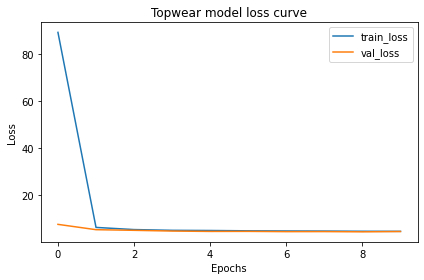

In [20]:
plt.plot(top_history.history['loss'], label='train_loss')
plt.plot(top_history.history['val_loss'], label='val_loss')
plt.title("Topwear model loss curve")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

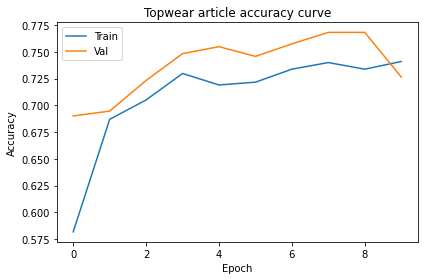

In [21]:
plt.plot(top_history.history['articleType_accuracy'], label='Train')
plt.plot(top_history.history['val_articleType_accuracy'], label='Val')
plt.title("Topwear article accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

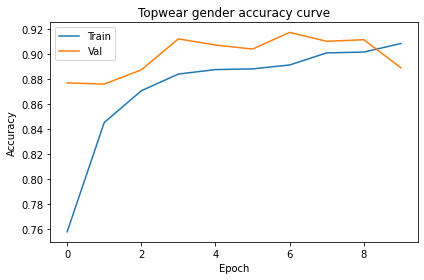

In [22]:
plt.plot(top_history.history['gender_accuracy'], label='Train')
plt.plot(top_history.history['val_gender_accuracy'], label='Val')
plt.title("Topwear gender accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

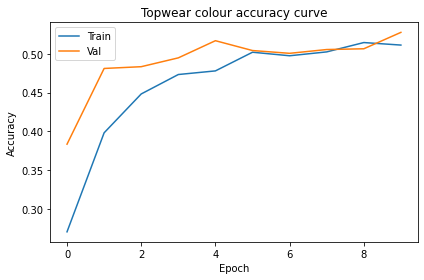

In [23]:
plt.plot(top_history.history['baseColour_accuracy'], label='Train')
plt.plot(top_history.history['val_baseColour_accuracy'], label='Val')
plt.title("Topwear colour accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

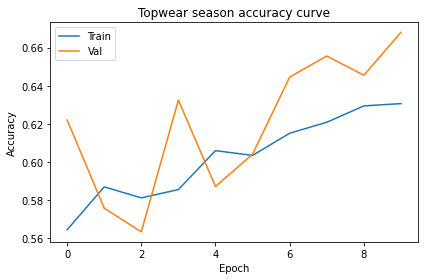

In [24]:
plt.plot(top_history.history['season_accuracy'], label='Train')
plt.plot(top_history.history['val_season_accuracy'], label='Val')
plt.title("Topwear season accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

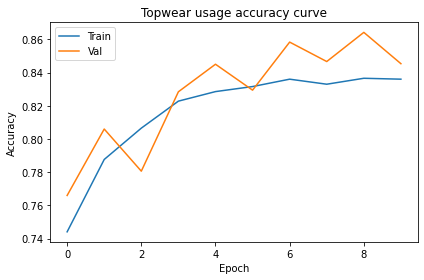

In [25]:
plt.plot(top_history.history['usage_accuracy'], label='Train')
plt.plot(top_history.history['val_usage_accuracy'], label='Val')
plt.title("Topwear usage accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Bottomwear recommendation

In [26]:
# model for bottomwear
batch_size = 32

bottom_base_model = build_model(80, 60, bottom_article, bottom_gender, bottom_color, bottom_season, bottom_usage)

bottom_train, bottom_val, bottom_test = split_data(create_array(bottomwear_df),batch_size)
bottom_base_model.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])

In [27]:
# plot_model(bottom_base_model, to_file='model_bottomwear.png')

with tf.device("/gpu:0"):
    bottom_history = bottom_base_model.fit(bottom_train, epochs=15, validation_data=bottom_val)

Epoch 1/15
50/50 [==============================] - 23s 409ms/step - loss: 346.6144 - articleType_loss: 2.4532 - gender_loss: 1.1717 - baseColour_loss: 2.5619 - season_loss: 1.2112 - usage_loss: 1.2900 - articleType_accuracy: 0.2731 - gender_accuracy: 0.5150 - baseColour_accuracy: 0.2200 - season_accuracy: 0.5188 - usage_accuracy: 0.6006 - val_loss: 149.6290 - val_articleType_loss: 1.8007 - val_gender_loss: 0.7948 - val_baseColour_loss: 2.0398 - val_season_loss: 0.8989 - val_usage_loss: 0.8520 - val_articleType_accuracy: 0.4414 - val_gender_accuracy: 0.5957 - val_baseColour_accuracy: 0.2773 - val_season_accuracy: 0.5781 - val_usage_accuracy: 0.6758
Epoch 2/15
50/50 [==============================] - 19s 380ms/step - loss: 88.2747 - articleType_loss: 1.8121 - gender_loss: 0.8260 - baseColour_loss: 2.0863 - season_loss: 0.8830 - usage_loss: 0.9103 - articleType_accuracy: 0.3988 - gender_accuracy: 0.6306 - baseColour_accuracy: 0.3000 - season_accuracy: 0.5594 - usage_accuracy: 0.6925 - va

In [28]:
bottom_base_model.evaluate(bottom_test)
bottom_base_model.save("/models/models/model_bottomwear")

16/16 [==============================] - 5s 281ms/step - loss: 5.8477 - articleType_loss: 1.4028 - gender_loss: 0.5488 - baseColour_loss: 1.5307 - season_loss: 0.8568 - usage_loss: 0.6476 - articleType_accuracy: 0.5254 - gender_accuracy: 0.7715 - baseColour_accuracy: 0.5020 - season_accuracy: 0.5938 - usage_accuracy: 0.7383
INFO:tensorflow:Assets written to: /Users/zkahmad/Library/CloudStorage/GoogleDrive-zebakarin@gmail.com/My Drive/Masters/Sem 2/DS/Project/outfit_recommendation_miniproject/Run/models/models/model_bottomwear/assets


#### Learning curves

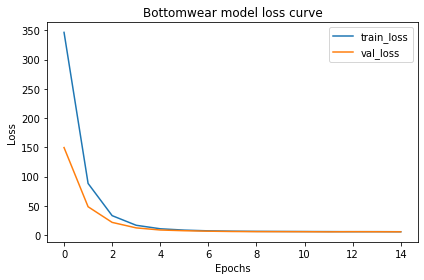

In [29]:
plt.plot(bottom_history.history['loss'], label='train_loss')
plt.plot(bottom_history.history['val_loss'], label='val_loss')
plt.title("Bottomwear model loss curve")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

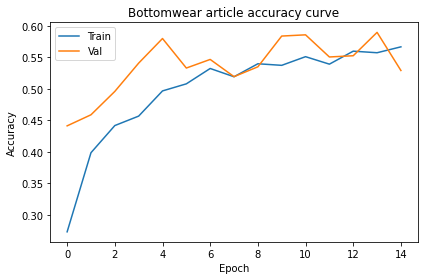

In [30]:
plt.plot(bottom_history.history['articleType_accuracy'], label='Train')
plt.plot(bottom_history.history['val_articleType_accuracy'], label='Val')
plt.title("Bottomwear article accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

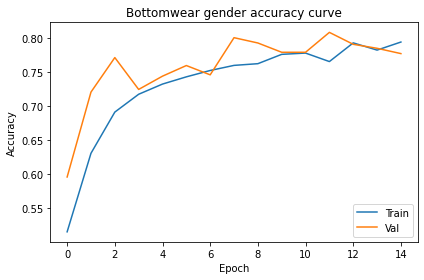

In [31]:
plt.plot(bottom_history.history['gender_accuracy'], label='Train')
plt.plot(bottom_history.history['val_gender_accuracy'], label='Val')
plt.title("Bottomwear gender accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

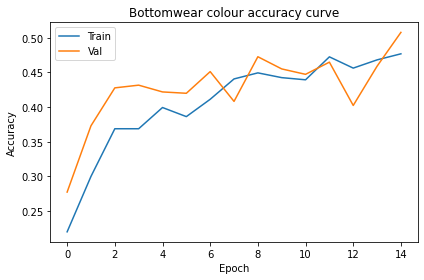

In [32]:
plt.plot(bottom_history.history['baseColour_accuracy'], label='Train')
plt.plot(bottom_history.history['val_baseColour_accuracy'], label='Val')
plt.title("Bottomwear colour accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

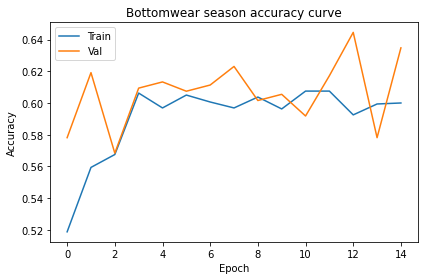

In [33]:
plt.plot(bottom_history.history['season_accuracy'], label='Train')
plt.plot(bottom_history.history['val_season_accuracy'], label='Val')
plt.title("Bottomwear season accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

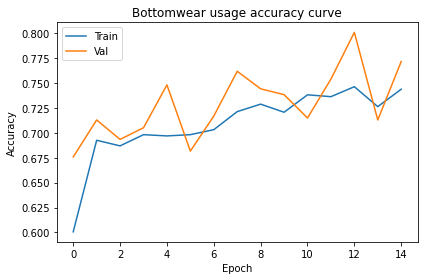

In [34]:
plt.plot(bottom_history.history['usage_accuracy'], label='Train')
plt.plot(bottom_history.history['val_usage_accuracy'], label='Val')
plt.title("Bottomwear usage accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Footwear recommendation

In [35]:
# model for footwear
batch_size = 32

foot_base_model = build_model(80, 60, foot_article, foot_gender, foot_color, foot_season, foot_usage)

foot_train, foot_val, foot_test = split_data(create_array(footwear_df), batch_size)
foot_base_model.compile(optimizer='adam',
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                        metrics=['accuracy'])

In [36]:
# plot_model(foot_base_model, to_file='model_footwear.png')

with tf.device("/gpu:0"):
    foot_history = foot_base_model.fit(foot_train, epochs=5, validation_data=foot_val)

Epoch 1/5
172/172 [==============================] - 68s 381ms/step - loss: 127.0086 - articleType_loss: 1.6914 - gender_loss: 0.8392 - baseColour_loss: 1.9520 - season_loss: 1.2041 - usage_loss: 0.7545 - articleType_accuracy: 0.3552 - gender_accuracy: 0.7044 - baseColour_accuracy: 0.3908 - season_accuracy: 0.4631 - usage_accuracy: 0.7037 - val_loss: 12.7591 - val_articleType_loss: 1.3490 - val_gender_loss: 0.6447 - val_baseColour_loss: 1.6004 - val_season_loss: 1.0573 - val_usage_loss: 0.5685 - val_articleType_accuracy: 0.4485 - val_gender_accuracy: 0.7571 - val_baseColour_accuracy: 0.5307 - val_season_accuracy: 0.5192 - val_usage_accuracy: 0.7856
Epoch 2/5
172/172 [==============================] - 70s 410ms/step - loss: 8.3058 - articleType_loss: 1.3804 - gender_loss: 0.6719 - baseColour_loss: 1.6370 - season_loss: 1.1001 - usage_loss: 0.6071 - articleType_accuracy: 0.4451 - gender_accuracy: 0.7622 - baseColour_accuracy: 0.4867 - season_accuracy: 0.5196 - usage_accuracy: 0.7469 - va

In [37]:
foot_base_model.evaluate(foot_test)
foot_base_model.save("/models/models/model_footwear")

57/57 [==============================] - 16s 279ms/step - loss: 5.3410 - articleType_loss: 1.0893 - gender_loss: 0.5764 - baseColour_loss: 1.3982 - season_loss: 1.0426 - usage_loss: 0.4871 - articleType_accuracy: 0.5510 - gender_accuracy: 0.8026 - baseColour_accuracy: 0.5751 - season_accuracy: 0.5340 - usage_accuracy: 0.7703
INFO:tensorflow:Assets written to: /Users/zkahmad/Library/CloudStorage/GoogleDrive-zebakarin@gmail.com/My Drive/Masters/Sem 2/DS/Project/outfit_recommendation_miniproject/Run/models/models/model_footwear/assets


#### Learning curves

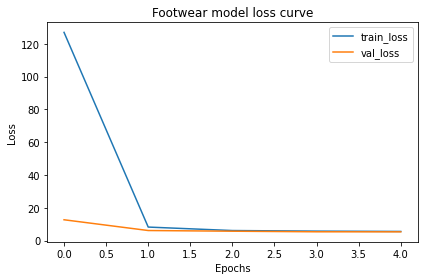

In [38]:
plt.plot(foot_history.history['loss'], label='train_loss')
plt.plot(foot_history.history['val_loss'], label='val_loss')
plt.title("Footwear model loss curve")
plt.xlabel("Epochs"), plt.ylabel("Loss"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

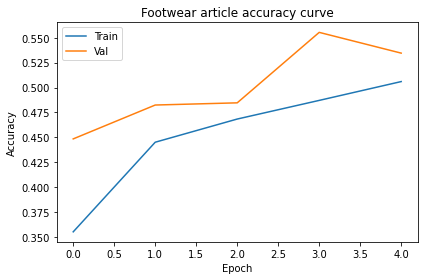

In [39]:
plt.plot(foot_history.history['articleType_accuracy'], label='Train')
plt.plot(foot_history.history['val_articleType_accuracy'], label='Val')
plt.title("Footwear article accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

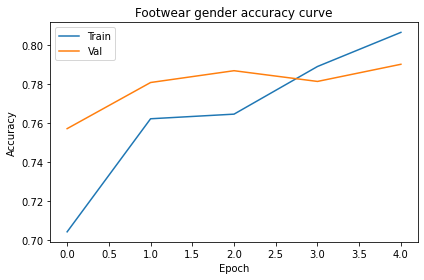

In [40]:
plt.plot(foot_history.history['gender_accuracy'], label='Train')
plt.plot(foot_history.history['val_gender_accuracy'], label='Val')
plt.title("Footwear gender accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

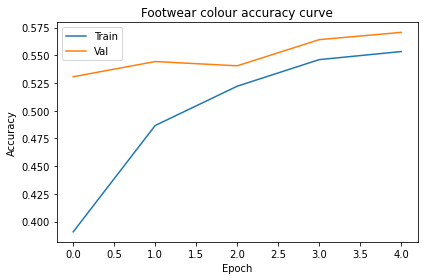

In [41]:
plt.plot(foot_history.history['baseColour_accuracy'], label='Train')
plt.plot(foot_history.history['val_baseColour_accuracy'], label='Val')
plt.title("Footwear colour accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

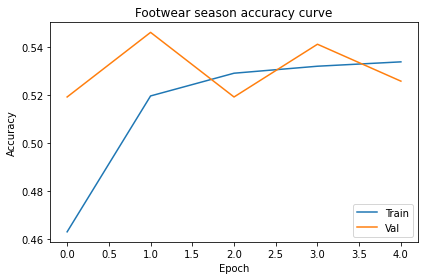

In [42]:
plt.plot(foot_history.history['season_accuracy'], label='Train')
plt.plot(foot_history.history['val_season_accuracy'], label='Val')
plt.title("Footwear season accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

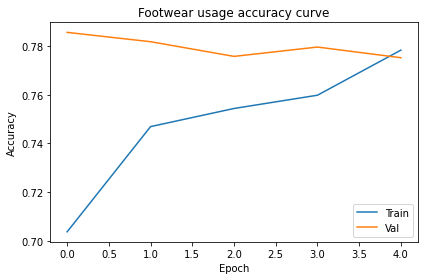

In [43]:
plt.plot(foot_history.history['usage_accuracy'], label='Train')
plt.plot(foot_history.history['val_usage_accuracy'], label='Val')
plt.title("Footwear usage accuracy curve")
plt.xlabel("Epoch"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.show()